In [29]:
import cv2
import Detect_inator
from detect import *
import Model_structure
import model
import train

In [43]:
model_my = model.load_model('dataset/weights/yolov3.cfg', 'dataset/weights/yolov3_ckpt_200.pth')

/mnt/c/Users/nickk/volleyball_cv_alg/model.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


In [2]:
import os
import pandas as pd

# Define paths
dataset_path = 'dataset'
splits = ['train', 'test', 'valid']

for split in splits: 
    # Path to the CSV file for each split
    csv_path = os.path.join(dataset_path, split, '_annotations.csv')
    images_folder = os.path.join(dataset_path, split, 'images')
    labels_folder = os.path.join(dataset_path, split, 'labels')

    # Create labels folder if it doesn't exist
    os.makedirs(labels_folder, exist_ok=True)

    # Load CSV
    data = pd.read_csv(csv_path)

    # Group data by filename to handle multiple boxes per image
    grouped = data.groupby('filename')

    for filename, group in grouped:
        # Get image dimensions from the first row (assuming they are the same for all boxes of the same image)
        width = group.iloc[0]['width']
        height = group.iloc[0]['height']
        
        # Prepare the label file path
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_filename)

        # Write bounding boxes to the label file
        with open(label_path, 'w') as f:
            for _, row in group.iterrows():
                class_id = row['class']  # Assuming 'player' is mapped to 0 if it's the only class
                xmin = row['xmin']
                ymin = row['ymin']
                xmax = row['xmax']
                ymax = row['ymax']
                
                # Convert to YOLO format
                x_center = ((xmin + xmax) / 2) / width
                y_center = ((ymin + ymax) / 2) / height
                box_width = (xmax - xmin) / width
                box_height = (ymax - ymin) / height

                # Write in the format: class_id x_center y_center box_width box_height
                f.write(f"0 {x_center} {y_center} {box_width} {box_height}\n")


In [5]:
import os
from glob import glob

# Define the root path to your dataset
dataset_root = "dataset"

# Define paths for each dataset split
splits = ["train", "valid", "test"]

# Function to create .txt files for each split
def create_txt_files(dataset_root, splits):
    for split in splits:
        # Path to the images folder
        images_path = os.path.join(dataset_root, split, "images")
        
        # Path to save the .txt file
        txt_file_path = os.path.join(dataset_root, f"{split}.txt")
        
        # Get list of all image files (adjust extension if necessary)
        image_files = glob(os.path.join(images_path, "*.jpg")) + glob(os.path.join(images_path, "*.png"))
        
        # Write image file paths to .txt file
        with open(txt_file_path, "w") as file:
            for image_path in image_files:
                file.write(f"{image_path}\n")
        
        print(f"{split}.txt created with {len(image_files)} entries at {txt_file_path}")

# Run the function
create_txt_files(dataset_root, splits)

train.txt created with 106 entries at dataset/train.txt
valid.txt created with 68 entries at dataset/valid.txt
test.txt created with 32 entries at dataset/test.txt


In [10]:
def draw_boxes(img, boxes):
    # Make a copy of the image to draw on
    img_copy = img.copy()

    for box in boxes:
        x1, y1, x2, y2, conf, cls = box
        
        # Convert coordinates to integers
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        
        # Draw rectangle
        color = (0, 255, 0)  # Green color for bounding box
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 2)
        
        # Prepare label text with confidence score
        label = f"player: {conf:.2f}"
        
        # Choose font and text size
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        
        # Calculate text size to create a background for readability
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        text_x, text_y = x1, y1 - 5  # Position above the box
        
        # Draw background rectangle for text
        cv2.rectangle(
            img_copy, 
            (text_x, text_y - text_size[1] - 2), 
            (text_x + text_size[0], text_y + 2), 
            color, 
            -1
        )
        
        # Draw label text on the image
        cv2.putText(
            img_copy, 
            label, 
            (text_x, text_y), 
            font, 
            font_scale, 
            (255, 255, 255),  # White color for text
            font_thickness
        )
    
    return img_copy

In [11]:
def display_image(img_with_boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(img_with_boxes)
    plt.axis('off')
    plt.savefig('output215.jpg')

In [44]:
img = cv2.imread('dataset/test/images/rally_women_mp4-5_jpg.rf.f47d1057723df439737420de079e3d28.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [47]:
boxes = detect_image(model_my, img, conf_thres=0.1, nms_thres=0.1)
boxes

array([[3.19159851e+02, 3.60983521e+02, 3.41726379e+02, 4.51040619e+02,
        3.83977532e-01, 0.00000000e+00],
       [4.87442871e+02, 3.81416626e+02, 5.08821472e+02, 4.79656189e+02,
        3.82482469e-01, 0.00000000e+00],
       [1.62727478e+02, 3.59300690e+02, 1.89724747e+02, 4.52596985e+02,
        3.72160077e-01, 0.00000000e+00],
       [2.24470184e+02, 3.79364075e+02, 2.52982758e+02, 4.82259888e+02,
        3.48198622e-01, 0.00000000e+00],
       [5.37705872e+02, 3.05046814e+02, 5.58574646e+02, 4.08708038e+02,
        3.26737791e-01, 0.00000000e+00],
       [1.97850159e+02, 3.42070648e+02, 2.25940582e+02, 4.20845154e+02,
        2.58776695e-01, 0.00000000e+00],
       [4.36221588e+02, 3.15037628e+02, 4.60049072e+02, 3.98688080e+02,
        2.23409578e-01, 0.00000000e+00],
       [1.83750015e+02, 3.30213165e+02, 2.03438934e+02, 3.96117615e+02,
        2.09628150e-01, 0.00000000e+00],
       [3.63820618e+02, 3.26323792e+02, 3.86015045e+02, 4.24402191e+02,
        1.57160848e-01, 

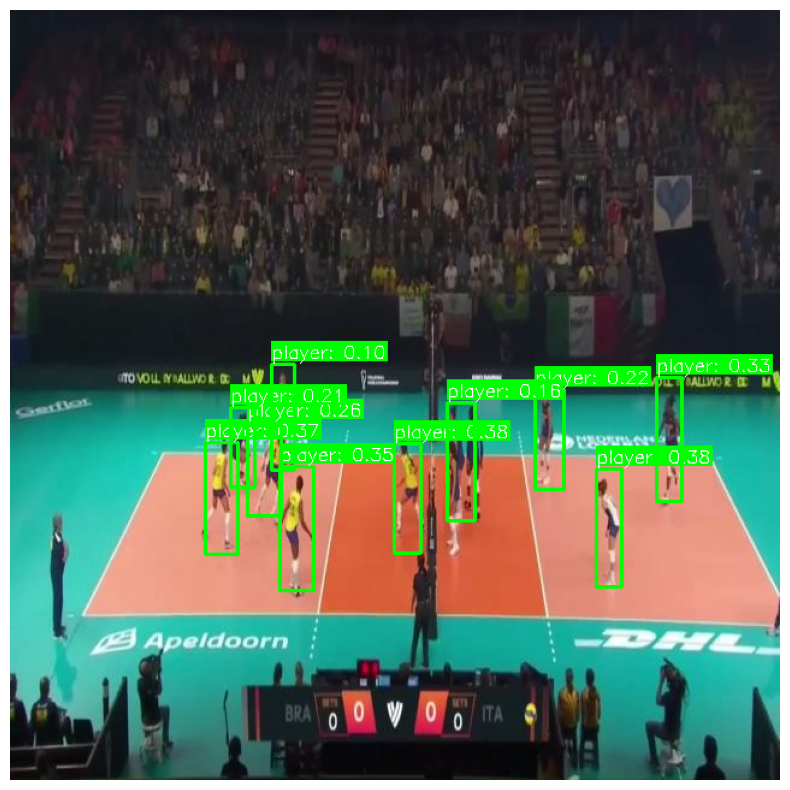

In [48]:
img_with_boxes = draw_boxes(img, boxes)
display_image(img_with_boxes)

In [ ]:
cv2.imshow("Image with Boxes", img_with_boxes)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
test_data = pd.read_csv('dataset/train/_annotations.csv')

In [4]:
test_data

,filename,width,height,class,xmin,ymin,xmax,ymax
0,volley-76-_png.rf.055cd0a41516a2b5d3a10e8a321f...,640,640,player,74,138,110,284
1,volley-76-_png.rf.055cd0a41516a2b5d3a10e8a321f...,640,640,player,201,140,232,317
2,volley-76-_png.rf.055cd0a41516a2b5d3a10e8a321f...,640,640,player,150,137,204,361
3,volley-76-_png.rf.055cd0a41516a2b5d3a10e8a321f...,640,640,player,0,128,46,380
4,volley-76-_png.rf.055cd0a41516a2b5d3a10e8a321f...,640,640,player,196,197,265,376
...,...,...,...,...,...,...,...,...
1015,volley-103-_png.rf.f5d1869da6b094a1e9639de52b1...,640,640,player,592,288,640,431
1016,volley-103-_png.rf.f5d1869da6b094a1e9639de52b1...,640,640,player,105,327,159,478
1017,volley-103-_png.rf.f5d1869da6b094a1e9639de52b1...,640,640,player,474,334,508,519
1018,volley-103-_png.rf.f5d1869da6b094a1e9639de52b1...,640,640,player,389,357,448,521


In [11]:
test_data.query('filename == "rally_women_mp4-1_jpg.rf.9358bbdf94234961674ace645202858f.jpg"')

,filename,width,height,class,xmin,ymin,xmax,ymax
484,rally_women_mp4-1_jpg.rf.9358bbdf94234961674ac...,640,640,player,195,351,215,406
485,rally_women_mp4-1_jpg.rf.9358bbdf94234961674ac...,640,640,player,187,386,210,469
486,rally_women_mp4-1_jpg.rf.9358bbdf94234961674ac...,640,640,player,212,401,232,485
487,rally_women_mp4-1_jpg.rf.9358bbdf94234961674ac...,640,640,player,249,381,273,455
488,rally_women_mp4-1_jpg.rf.9358bbdf94234961674ac...,640,640,player,263,394,281,477
489,rally_women_mp4-1_jpg.rf.9358bbdf94234961674ac...,640,640,player,329,385,341,470
490,rally_women_mp4-1_jpg.rf.9358bbdf94234961674ac...,640,640,player,331,351,344,427
491,rally_women_mp4-1_jpg.rf.9358bbdf94234961674ac...,640,640,player,341,359,357,450
492,rally_women_mp4-1_jpg.rf.9358bbdf94234961674ac...,640,640,player,380,342,402,418
493,rally_women_mp4-1_jpg.rf.9358bbdf94234961674ac...,640,640,player,436,408,455,489
